# Two excitation limit SSH Model
Now the Hamiltonian is of the form:
$$H=H_{SSH}+H_{int}$$
Where the Hamiltonian of the interaction is:
$$H_{int}=\frac{1}{2}\sum_i U a_i^\dagger a_i^\dagger a_i a_i=\frac{1}{2}\sum_i U n_i(n_i-1)  $$
The basis in which we will be working is:
$$\mathfrak{B}=\left\{ |10 \cdots 010 \cdots \rangle , |020\cdots 0\rangle, \cdots \right\}$$
Where the first ket represents a bosonic excitation in the first cell and another in the i-th cell, the second ket represents the two bosons in the second cell.

As the particles with which we are working are bosons there can be two of them in the same state.

In [73]:
#If this variable is True it displays the numerical values of the eigenvalues and eigenvectors
DisplayNumericalValues=False
#With Numba I can calculate all about a n=50 chain in 2:30 minutes!!!!!!

In [74]:
#Import libraries 
from sympy.interactive import printing
printing.init_printing(use_latex = True)

import numpy as np
import sympy as sp
import scipy as sc
from scipy.misc import derivative
from sympy import *
from numpy.linalg import eig
from numpy import sin
from numpy import pi
from sympy import Array
from sympy.matrices import Matrix
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gs
import numba
from numba.types import *
from numba import prange
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib
#This sets a font similar to the one used by LaTeX
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#Size of the font used on the plots
matplotlib.rcParams['font.size']=20

In [75]:
#Here we consider m=1, ħ=1 and a lattice with distance L=1 between each site, so the lattice constant is 2
N=20 #Number of sites on the chain
J1=0.1 #Intra-cell hopping
J2=1 #Inter-cell hopping
#If J2>J1 we're in the topological phase
JM=max(J1, J2)
Jm=min(J1, J2)
U=5*JM #Interaction energy between the two excitations
ω=0 #On-site potential
weight=0.01 #Random perturbation to the onsite potential ω0 -> ω in [ω0-weight, ω0+weight]

In [76]:
#Annihilation operator
@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a(n):
    if n == 0:
        return (0,0)
    else:
        return (n-1, np.sqrt(n))
#Creation operator
@numba.jit(numba.types.Tuple((float64, float64))(float64), nopython = True, parallel = False)
def a_plus(n):
    return (n+1, np.sqrt(n+1))

In [77]:
#Function that computes the bra-ket of two states
@numba.jit(float64(float64[:],float64[:]), nopython = True, parallel = False)
def bracket(bra1, ket1):
    if np.all(bra1 == ket1):
        return 1
    else:
        return 0

In [78]:
#Linear function (It's used to fit the edge states)

#@numba.jit(float64[:](int32[:], float64), nopython=True, fastmath=True, parallel=False)
def func(x, λ, A):
    return ((x-A)/λ)

In [79]:
#Function that computes a matrix element of the Hamiltonian between states <bra| and |ket> <bra|H|ket>
@numba.jit(float64(float64[:],float64[:],float64, int64, float64), nopython = True, parallel = False)
def Elemento_matriz_Hamiltoniano(bra, ket, U, N, ω):
    n_eigval=N*(N+1)/2
    H=0

    ket_aux = np.empty(len(ket))
    ket_aux2 = np.empty(len(ket))
    bra_aux = np.empty(len(ket))

    bracket1 = bracket(bra, ket)
    #On-site interaction term of the Hamiltonian ω*Σ_i (n_i <bra|ket>)
    H += np.sum(ω*ket*bracket1) 
    #Inter-particle interaction term of the Hamiltonian U/2*Σ_i (n_i(n_i-1) <bra|ket>)
    H += np.sum(0.5*U*ket*(ket-1)*bracket1)
    
    #Compute the boundaries of the system: Typically we set Hard Boundary Conditions, but Periodic Boundary
    #Conditions can be chosen too.
    ket_aux[:] = ket
    ket_aux2[:] = ket
    bra_aux[:] = bra
    if (N-1)%2==0:
        J=-J1
    else:
        J=-J2
    #P.B.C.
    #ket_aux[0], coef_term2=a(ket_aux[0])
    #H.B.C.
    ket_aux[0], coef_term2=0,0
    ket_aux[N-1], coef_term2_aux=a_plus(ket_aux[N-1])
    term2 = J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
    ket_aux2[N-1], coef_term3=a(ket_aux2[N-1])
    #P.B.C.
    #ket_aux2[0], coef_term3_aux=a_plus(ket_aux2[0])
    #H.B.C.
    ket_aux2[0], coef_term3_aux=0,0
    term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)
    H+=term2+term3
    
    for i in range(len(ket)-1):
            ket_aux[:] = ket
            ket_aux2[:] = ket
            bra_aux[:] = bra
            #coef_term2=coef_term2_aux=coef_term3=coef_term3_aux=0
            if i%2==0:
                J=-J1
            else:
                J=-J2
            #Term J a^+_i a_(i+1)
            ket_aux[i+1], coef_term2 = a(ket_aux[i+1])
            ket_aux[i], coef_term2_aux=a_plus(ket_aux[i])
            term2=J*coef_term2*coef_term2_aux*bracket(bra_aux, ket_aux)
            #Term J a^+_(i+1) a_i
            ket_aux2[i], coef_term3=a(ket_aux2[i])
            ket_aux2[i+1], coef_term3_aux=a_plus(ket_aux2[i+1])
            term3=(J)*coef_term3*coef_term3_aux*bracket(bra_aux, ket_aux2)

            #print(term2, term3)
            H+=term2+term3
    #print("\n")
    return H

In [80]:
#Construct two particle-basis
#|200...>, |110...>, |101...>,...
Identity=np.identity(N)
n_eigval=int(N*(N+1)/2) #Number of states on the basis
base=np.empty((n_eigval, N))
counter=0
for l in range(N):
    for k in range(l,N):
        ketB=Identity[k,:]+Identity[l,:]
        #print(ketB)
        base[counter, :]=ketB
        counter+=1
if DisplayNumericalValues:
    for i in range(len(base[:,0])):
        print((base[i,:]))
        
n_eigval=int(N*(N+1)/2)
#Construct the random perturbation to the potential
#ω_array is a N-component array and has the perturbed potential on each site of the chain
if ω==0:
    ω_array=(2*weight*(np.random.rand(N)-0.5))
else:
    ω_array=ω*(1+2*weight*(np.random.rand(N)-0.5))
#ω_matrix is a N(N+1)/2 x N(N+1)/2 matrix which has the average of the two onsite potentials
#in e.g. |0100100...> the 2nd and 5th sites
ω_matrix=np.zeros((n_eigval, n_eigval))
counter=0
for l in range(N):
    for k in range(l,N):
        ω_matrix[counter, counter]=(ω_array[l]+ω_array[k])/2
        counter+=1

In [81]:
#This function computes all of the matrix elements of the Hamiltonian given the basis of the system
@numba.jit(float64[:,:](float64,float64[:,:], int64), nopython = True, parallel = False)
def ComputeH(U,base, N):
    H = np.empty((n_eigval,n_eigval))
    for i2 in range(n_eigval):
        for j2 in range(n_eigval):
            H[i2,j2]=Elemento_matriz_Hamiltoniano(base[i2],base[j2], U, N, ω_matrix[i2, j2])
    return H

In [82]:
#This function computes the 1-particle Hamiltonian very fast as its matrix is easy
#It doesn't work with the 2 particle Hamiltonian
@numba.jit(float64[:, :](int64, float64, float64), nopython=True, parallel=False)
def FastHamiltonian(N, J1, J2):
    aux_N=int(N/2) #Numero de celdas
    H_int1=np.asarray([[0, 1], [1, 0]])
    aux1=np.kron(np.eye(aux_N), H_int1)
    aux2=np.eye(N, k=1)+np.eye(N, k=-1)-aux1
    aux3=np.zeros((N, N))
    for i in range(N):
        aux3[i, i]=ω_array[i]
    H=J1*aux1+J2*aux2+aux3
    #print(H)
    return H

In [83]:
#This function computes the indexes of the states which are Bulk-Bulk, BUlk-Edge and Edge-Edge
#for the 2-particle SSH model. It only works when U=0.
@numba.jit(numba.types.Tuple((int64[:], int64[:], int64[:], float64[:], float64[:, :]))(int64), nopython = True, parallel = False)
def ComputeIndexes(N):    
    H1p=FastHamiltonian(N, J1, J2)
    eigval1p, eigvect1p=eig(H1p)
    idx1p = np.argsort(eigval1p)
    eigval1p = eigval1p[idx1p]
    eigvect1p=eigvect1p[:, idx1p]
    
    if DisplayNumericalValues:
        print(eigval1p)
    eigvalNeg=eigval1p[:int(N/2)]
    if J2>J1:
        InterestingIndex=np.argmax(eigvalNeg)
    else:
        InterestingIndex=-100000
    E_teorIndep=[]
    eigvect_teorIndep=np.empty((N, n_eigval))
    NumberIterations=0
    IndexEdgeEdge=[]
    IndexBulkEdge=[]
    counter=0
    #Edge_Edge_Energies=[2*eigval1p[InterestingIndex], eigval1p[InterestingIndex]+ eigval1p[InterestingIndex+1], 2*eigval1p[InterestingIndex+1]]
    for i in range(N):
        for j in range (i,N):
            E_teorIndep.append(eigval1p[i]+eigval1p[j])
            eigvect_teorIndep[:, counter]=(eigvect1p[:, i]*eigvect1p[:, j]+eigvect1p[:, j]*eigvect1p[:, i])/(np.sqrt(np.sum(np.abs((eigvect1p[:, i]*eigvect1p[:, j]+eigvect1p[:, j]*eigvect1p[:, i])**2))))
            if i== InterestingIndex or i==InterestingIndex+1:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexEdgeEdge.append(counter)
                else:
                    IndexBulkEdge.append(counter)
            else:
                if j== InterestingIndex or j==InterestingIndex+1:
                    IndexBulkEdge.append(counter)
            counter+=1
    E_teorIndep=np.asarray(E_teorIndep)
    idx=np.argsort(E_teorIndep)
    E_teorIndep=E_teorIndep[idx]
    eigvect_teorIndep=eigvect_teorIndep[:, idx]
    for i in range(len(IndexEdgeEdge)):
        IndexEdgeEdge[i]=np.argmin(np.abs(idx-IndexEdgeEdge[i]))
    for i in range(len(IndexBulkEdge)):
        IndexBulkEdge[i]=np.argmin(np.abs(idx-IndexBulkEdge[i]))
    IndexBulkBulk=[]
    for k in range(len(E_teorIndep)):
        if k in IndexBulkEdge :
            dummy=1
        elif k in IndexEdgeEdge:
            dummy=2
        else:
            IndexBulkBulk.append(k)
    IndexEdgeEdge=np.asarray(IndexEdgeEdge)
    IndexBulkEdge=np.asarray(IndexBulkEdge)
    IndexBulkBulk=np.asarray(IndexBulkBulk)
    #print(IndexEdgeEdge)
    #print(out)
    return (IndexEdgeEdge, IndexBulkEdge, IndexBulkBulk, E_teorIndep, eigvect_teorIndep)

In [84]:
#We compute the Hamiltonian matrix
H=ComputeH(U, base, N)
if DisplayNumericalValues:
    print(H)

In [85]:
#Compute the eigenvalues and eigenvectors of the Hamiltonian
eigval, eigvect=eig(H)
#Order the eigenvalues and eigenvectors in increasing energy
idx = np.argsort(eigval) 
eigval = eigval[idx]
eigvect=eigvect[:,idx]
#We make sure that the Schrödinger equation holds
#We compute |H|ψ>-E|ψ>| for every eigenvector |ψ> and if any of the values of the vector 
#is bigger than 1e-12 (numerical precission issues) it displays a warning
for i in range(len(eigval)):
    CompEqSchrod=np.abs(np.matmul(H, eigvect[:, i])-eigval[i]*eigvect[:,i]) 
    if (np.any(CompEqSchrod>1e-12)):
        print("PROBLEMS")
        print(CompEqSchrod)
if DisplayNumericalValues:
    print(eigvect)
    #print(sum(eigvect[:,IndexEdgeEdge]**2))

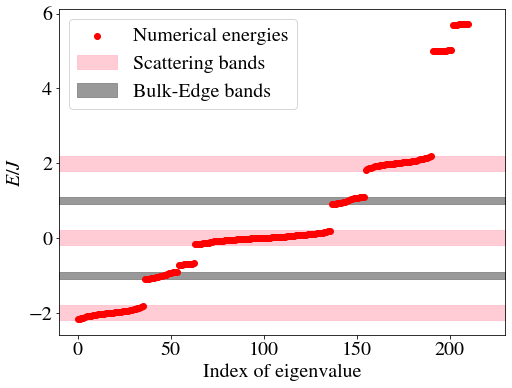

In [86]:
#Make the energy plot
a=np.linspace(0,len(eigval), len(eigval))
#E_analytical_Dimer=np.asarray([2*ω+ U - np.sqrt(U**2+4*J1**2),2*ω+2*U,2*ω+ U + np.sqrt(U**2+4*J1**2) ])
plt.figure(figsize=[8, 6])
if U==0:
    #We compute the BB, BE and EE indexes with the function
    IndexEdgeEdge, IndexBulkEdge, IndexBulkBulk, E_teorIndep, eigvectIndep=ComputeIndexes(N)
    plt.scatter(a[IndexBulkBulk], eigval[IndexBulkBulk],s=8, color='red', label ='Bulk-Bulk States', zorder=10)
    plt.scatter(a[IndexEdgeEdge], eigval[IndexEdgeEdge], s=8,color='blue', label='Edge-Edge States', zorder=10)
    plt.scatter(a[IndexBulkEdge], eigval[IndexBulkEdge],s=8,  color='black', label='Bulk-Edge States', zorder=10)
else:
    #We plot the numerical energies 
    plt.scatter(a, eigval, color='red', label='Numerical energies')
#plt.plot(a, E_teorIndep, color='black', label='Non interacting bosons')
#plt.scatter(a, E_teorIndep, color='black', label='Non interacting bosons')
#plt.plot(a, E_analytical_Dimer, color='blue', label='Analytical results for Dimer')
plt.xlim(-10, 230)
aplot=np.linspace(-10, 230, 10)
#plt.savefig("DispersionRelation.png")
plt.ylabel("$E/J$")
plt.xlabel("Index of eigenvalue")
#plt.fill_between(aplot, -4, 4, alpha=0.8, color='pink', zorder=0, label='Scattering Band')

#Fill the area of Scattering and Bulk-Edge Bands, only works nice if we're in the strongly dimerized limit
plt.fill_between(aplot, 2*J2-2*J1, 2*J2+2*J1, alpha=0.8, color='pink', zorder=0, label='Scattering bands')
plt.fill_between(aplot, -2*J1, 2*J1, alpha=0.8, color='pink', zorder=0)
plt.fill_between(aplot, -2*J2-2*J1, -2*J2+2*J1, alpha=0.8, color='pink', zorder=0)
plt.fill_between(aplot, J1+J2, J2-J1, alpha=0.8, color='gray', zorder=0, label='Bulk-Edge bands')
plt.fill_between(aplot, J1-J2, -J2-J1, alpha=0.8, color='gray', zorder=0)
plt.legend()
plt.show()
#print(eigval.real)
#np.savetxt('energiesU5.txt', np.column_stack([a,eigval]))

In [87]:
#"Project" the eigenvectors on the chain, this means that state |200...> has weight 2 on the 1st site
# and state |0101...> has weight 1 on the 2nd and 4th sites
eigvecRealSpace=[[]]
eigvecRealSpace=np.matmul(base.transpose(), eigvect)
eigvecRealSpace=np.asarray(eigvecRealSpace)
#Normalize the eigenvectors in the 1D representation
for j in range(n_eigval):
    eigvecRealSpace[:, j]=eigvecRealSpace[:,j]/np.sqrt(sum(np.abs(eigvecRealSpace[:,j])**2))
#print(np.sum(np.abs(eigvectIndep**2), axis = 0))

3.1010415520052383 1.5118867288833007
-1.4395780820272672 0.5800127919270806


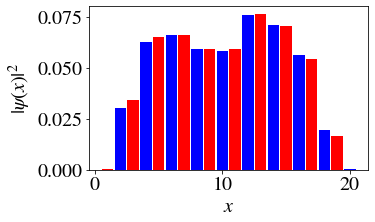

In [88]:
#This function plots the 1D representation of the eigenvector with index i_Eig
def PlotEigvect(i_Eig, eigvecRealSpace, eigvectIndep, auxpos):
    #Expresiones analíticas para N=2
    """α0=np.sqrt(J1**2/(U**2+4*J1**2+U*np.sqrt(U**2+4*J1**2)))
    α2=np.sqrt(J1**2/(U**2+4*J1**2-U*np.sqrt(U**2+4*J1**2)))
    γ0=(-U-np.sqrt(U**2+4*J1**2))/(np.sqrt(2)*J1)
    γ2=(-U+np.sqrt(U**2+4*J1**2))/(np.sqrt(2)*J1)
    ψB=np.asarray([[α0, α0*γ0, α0], [1/np.sqrt(2), 0, -1/np.sqrt(2)], [α2, α2*γ2, α2]])
    ψBp=np.asarray([[2*α0+α0*γ0,2*α0+α0*γ0], [np.sqrt(2), -np.sqrt(2)], [2*α2+α2*γ2,2*α2+α2*γ2] ])
    """
    aux_eig=(abs(eigvecRealSpace[:, i_Eig]))**2
    x=np.arange(1, N+1, 1)
    #analytical_eig_Dimer=(abs(ψBp[i_Eig, :]))**2
    #xTeor=np.arange(0,L*len(analytical_eig_Dimer), 1)
    
    #Contribution to the wavefunction in each of the sublattices
    eigA= aux_eig[::2]
    eigB=aux_eig[1::2]
    
    minA=np.argmin(eigA)
    minB=np.argmin(eigB)
    maxA=np.argmax(eigA)
    maxB=np.argmax(eigB)
    xA=np.arange(1, len(eigvecRealSpace[:, 0])+1, 2 )
    xB=np.arange(2, len(eigvecRealSpace[:, 0])+1, 2)
    
    #Linear fit to the edge states in log scale
    if maxA>minA:
        eigAuxA=eigA[minA:maxA+1]
        xAuxA=xA[minA:maxA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    else:
        eigAuxA=eigA[maxA:minA+1]
        xAuxA=xA[maxA:minA+1]
        mA, nA, trash, trash1, errA=linregress(xAuxA, np.log(eigAuxA))
    if maxB>minB:
        eigAuxB=eigB[minB:maxB+1]
        xAuxB=xB[minB:maxB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    else:
        eigAuxB=eigB[maxB:minB+1]
        xAuxB=xB[maxB:minB+1]
        mB, nB, trash, trash1, errB=linregress(xAuxB, np.log(eigAuxB))
    plt.figure(figsize=[5, 3])
    #plt.subplot2grid((3,6), auxpos)
    plt.bar(xA, eigA, width=0.9,color='red', label='Sublattice A ', zorder=0)
    plt.bar(xB, eigB, color='blue', width=0.9, label='Sublattice B ', zorder=0)
    if np.sign(mA)==np.sign(mB):
        m=(mA+mB)/2
        n=(nA+nB)/2
        #plt.plot(x, np.exp(m*x+n), color='black', label='Exponential fit')
        #if m>0:
            #plt.text(3, 0.1, r"$\xi=$"+"%.2f" % (1/m))
        #else:
            #plt.text(N-6, 0.1, r"$\xi=$"+"%.2f" % (1/m))
        print(1/m, np.sqrt((errA/mA**2)**2+(errB/mB**2)**2))
    else:
        #plt.plot(xAuxA, np.exp(mA*xAuxA+nA), color='red', label='Exponential fit A')
        #plt.plot(xAuxB, np.exp(mB*xAuxB+nB), color='blue', label='Exponential fit B')
        m=(np.abs(mA)+np.abs(mB))/2
        #plt.text(8, 0.05, r"$\xi=\pm$"+"%.2f" % (1/m))
        print(1/mA, errA/mA**2)
        print(1/mB, errB/mB**2)
    #plt.scatter(x, (abs(eigvectIndep[:, i]))**2, zorder=10, color='black', s=35)
    #plt.plot(xTeor, analytical_eig_Dimer, color='black', label='Analytical eigenvector')
    plt.xlabel("$x$")
    plt.ylabel("$| \psi(x)|^2$")
    #plt.title("Eigenvector number "+ str(i_Eig)+" using J1="+ str(J1)+" J2="+str(J2))
    plt.savefig('EigenVector'+str(i_Eig)+'.png')
    #plt.yscale('log')
    #plt.legend()
    plt.show()

aux=np.arange(190, 210, 1)
#for i in aux:
    #PlotEigvect(i, eigvecRealSpace, eigvectIndep)
eigvectIndep=np.asarray([])
#for i in aux:
    #PlotEigvect(i, eigvecRealSpace, eigvectIndep)
dummy=0
PlotEigvect(0, eigvecRealSpace, eigvectIndep, dummy)

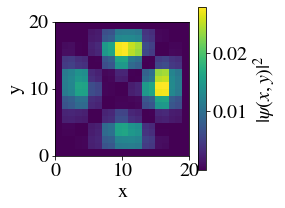

In [89]:
#This function makes the 2D representation of the wavefunction with index i_Eig
def PlotEigvect2D(i_Eig, eigvect, auxpos):
    EigV_i=(abs(eigvect[:, i_Eig]))**2
    #print(np.sum(EigV_i))
    
    #Maximum and minimum values of |ψ|^2
    maxV=np.max(EigV_i)
    minV=np.max(EigV_i)
    
    #Construct the 2D representation
    eigvect2D=np.zeros((N, N))
    #eigvect2Daux=np.zeros((N,N))
    counter=0
    for i in range(N):
        for j in range(i, N):
            eigvect2D[i, j]=EigV_i[counter]
            eigvect2D[j, i]=EigV_i[counter]
            counter+=1
            
    fig=plt.figure(figsize=[3,3])
    #plt.subplot2grid((3,6), auxpos)
    plt.gca().set_aspect('equal')
    plt.pcolor(eigvect2D)
    cb= plt.colorbar()
    cb.set_label(label=r'$|\psi(x,y)|^2$')
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.xticks(ticks=[0,20,40])
    """a=25
    x=np.linspace(0, a, 100)
    xa=np.linspace(0,20,100)
    xaa=np.linspace(0, a/2, 100)
    plt.plot(x, -x+a)
    plt.plot(xa, xa)
    plt.plot(a/2*np.ones(100),xaa)"""
    #fig.tick_params(label_size=15)
    #plt.title("Mapping of the 2-particle wavefunction to a 2D plot \n Each of the axis represents the position on the lattice of one particle")
    plt.savefig("2DPlotEigvect"+str(i_Eig)+".png")
    plt.show()
"""    x=np.arange(0, N, 1)
    plt.figure()
    auxplot=np.zeros(N)
    for i in range(N):
        auxplot[i]=np.sum(eigvect2D[:,i])
    plt.plot(x, auxplot)
    plt.show()"""
#for i in aux:
dummy=1
PlotEigvect2D( 1 ,  eigvect, dummy)

Definition of Participation Ratio (PR)

$$PR=\frac{\sum_{m,n} |\psi_{mn}|^2}{\sum_{m,n}|\psi_{mn}|^4}$$

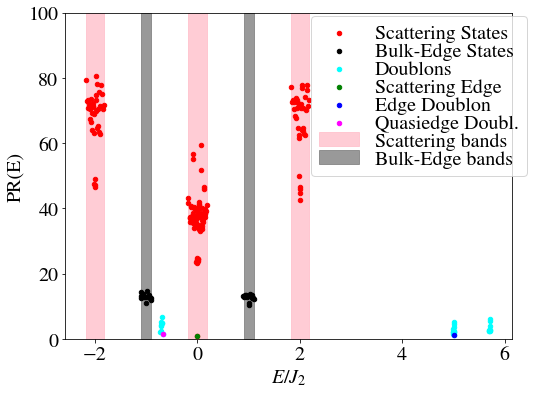

Indexes of array from lowest to highest PR
[ 95 194  62 192 191  54 200 193 196  55 195 201 209 202 203 205 204 190
 199  56 208  58 197  61  60  57 198 206 207  59 145 144  45  53 153  52
  50  51 152  38 150 151 142  44 137  46  42 138  48  37 146  43 136 143
 139 148  40  49 140 149  39 141 147  41  36  47  97  89  96 103 100  99
 102 101  98 116 111 110 120  78 114  82 124 115  84  90  77  92  83  81
  68 125  72 121  76  87 126  91  66  67  93 132 119 106  65 105  88  71
 127 107  94 133  73 122 130 104 134  85  86 131 109 123  79  80  69  70
 108 135 113  64 112 170  63 172 173 128 129 171  19  17  16  18 167 118
  74  75 117 166 169 184  30 182  15  28 180 178  10 164 179  25  26   7
   6 161 159  14   9  23 185  27 157  34   5 163 174   3 181  13 188  11
  31 168  35   4 175 165  12 155 158   1  20 189 156 162   2   8 160 183
  21  33  29 187 177 154  32 176 186  24   0  22]
1.040815718612409


'print("Participation Ratio")\nprint(InterestingEigVects)\nprint(participation_ratio[InterestingEigVects])\nprint("Number of occupied sites by the state")\nprint(NumberOccupiedSites[InterestingEigVects])'

In [90]:
#Participation ratio plot 

N_eigvect=len(eigvect[0, :])
participation_ratio=[]
NumberOccupiedSites=[]
#Compute PR
participation_ratio = np.sum(np.abs(eigvect**2), axis = 0) / np.sum(np.abs(eigvect**4), axis = 0)
participation_ratio=np.asarray(participation_ratio)
#Compute effective number of occupied sites (Not used)
NumberOccupiedSites=0.5*(np.sqrt(1+8*participation_ratio)-1)

plt.figure(figsize=[8, 6])
#gs.GridSpec(3,6)
#plt.subplot2grid((6,6), (0,0), rowspan=3, colspan=3)
a=np.linspace(0,len(eigvect[0, :]),len(eigvect[0,:]))
if U==0:
    plt.scatter(eigval[IndexBulkBulk],participation_ratio[IndexBulkBulk], s=10, label='B-B states', color='red')
    plt.scatter(eigval[IndexEdgeEdge],participation_ratio[IndexEdgeEdge], s=10, label='E-E states', color='blue')
    plt.scatter(eigval[IndexBulkEdge],participation_ratio[IndexBulkEdge], s=10, label='B-E states', color='black')
else:
    ScatteringIndex=[]
    BEIndex=[]
    DoublIndex=[]
    UnstDoublIndex=[]
    #eigval=eigval-2*ω
    
    #Distinguish which States are which
    #Only works in strongly dimerized model (where there is not overlap between the energy bands)
    for i in range(len(eigval)):
        if (eigval[i]>=-2*JM-2*Jm)&(eigval[i]<=-2*JM+2*Jm):
            ScatteringIndex.append(i)
        elif (eigval[i]>=-2*Jm)&(eigval[i]<=2*Jm):
            ScatteringIndex.append(i)
        elif (eigval[i]>=-2*Jm+2*JM)&(eigval[i]<=2*Jm+2*JM):
            ScatteringIndex.append(i)
        elif (eigval[i]>=-J1+J2-0.05)&(eigval[i]<=J2+J1+0.05):
            BEIndex.append(i)
        elif (eigval[i]>=-J1-J2-0.05)&(eigval[i]<=-J2+J1+0.05):
            BEIndex.append(i)
        else:
            DoublIndex.append(i)


    ScatteringIndex=np.asarray(ScatteringIndex)
    BEIndex=np.asarray(BEIndex)
    DoublIndex=np.asarray(DoublIndex)
    UnstDoublIndex=np.asarray(UnstDoublIndex)
    
    auxD=np.argsort(participation_ratio[DoublIndex])
    
    plt.scatter(eigval[ScatteringIndex], participation_ratio[ScatteringIndex], zorder=5, color='red', s=20, label='Scattering States')
    plt.scatter(eigval[BEIndex], participation_ratio[BEIndex], color='black', s=20, label='Bulk-Edge States')
    plt.scatter(eigval[DoublIndex], participation_ratio[DoublIndex], color='cyan', s=20, label='Doublons')
    #plt.scatter(eigval[UnstDoublIndex], participation_ratio[UnstDoublIndex], color='orange', s=10, label='Decaying Doublons')
    plt.scatter(eigval[ScatteringIndex[np.argmin(participation_ratio[ScatteringIndex])]], participation_ratio[ScatteringIndex[np.argmin(participation_ratio[ScatteringIndex])]], zorder=10, color='green', s=20, label='Scattering Edge')
    plt.scatter(eigval[DoublIndex[auxD[0]]], participation_ratio[DoublIndex[auxD[0]]],s=20, color='blue', zorder=10, label='Edge Doublon')
    plt.scatter(eigval[DoublIndex[auxD[1]]], participation_ratio[DoublIndex[auxD[1]]],s=20, color='magenta', zorder=10, label='Quasiedge Doubl.')
    #plt.scatter(eigval/J2, participation_ratio, zorder=5, color='red', s=20)
plt.xlabel("$E/J_2$")
plt.ylabel("PR(E)")
ymax=100

#Energy bands
plt.fill_between(eigval, 0, ymax, where=(eigval>-2*JM-2*Jm)&(eigval<-2*JM+2*Jm), alpha=0.8, color='pink', zorder=0, label='Scattering bands')
plt.fill_between(eigval, 0, ymax, where=(eigval>-2*Jm)&(eigval<2*Jm), alpha=0.8, color='pink', zorder=0)
plt.fill_between(eigval, 0, ymax, where=(eigval>-2*Jm+2*JM)&(eigval<2*Jm+2*JM), alpha=0.8, color='pink', zorder=0)
plt.fill_between(eigval, 0, ymax, where=(eigval>-J1+J2)&(eigval<J2+J1), alpha=0.8, color='gray', zorder=0, label='Bulk-Edge bands')
plt.fill_between(eigval,  0, ymax, where=(eigval>-J1-J2)&(eigval<-J2+J1), alpha=0.8, color='gray', zorder=0)
plt.ylim(0,100)
#plt.title("Participation ratio as a function of the Energy of the eigenstate")
plt.legend(loc=[0.55,0.5], labelspacing=0)
#plt.savefig("participation_ratio.png")
plt.show()
print("Indexes of array from lowest to highest PR")
print(np.argsort(participation_ratio))
print(np.min(participation_ratio))
#participation_ratio=np.asarray(participation_ratio)
"""print("Participation Ratio")
print(InterestingEigVects)
print(participation_ratio[InterestingEigVects])
print("Number of occupied sites by the state")
print(NumberOccupiedSites[InterestingEigVects])"""